In [1]:
## BASICS
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle, Wedge, Polygon
from IPython.display import display, HTML

## DSP
! pip install control
! pip install audiolazy
! pip install PyDynamic
from PyDynamic.identification.fit_filter import LSIIR
from scipy import signal, fftpack
import control
import cmath
import sympy


/usr/local/lib/python3.6/dist-packages/PyDynamic/identification/fit_filter.py:29: DeprecationWarning: The module *identification* will be combined with the module *deconvolution* and renamed to *model_estimation* in the next major release 2.0.0. From version 1.4.1 on you should only use the new module *model_estimation* instead.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/PyDynamic/identification/fit_transfer.py:28: DeprecationWarning: The package *identification* will be combined with the package *deconvolution* and renamed to *model_estimation* in the next major release 2.0.0. From version 1.4.1 on you should only use the new package *model_estimation* instead.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/PyDynamic/uncertainty/interpolation.py:28: PendingDeprecationWarning: The module :mod:`PyDynamic.uncertainty.interpolation` will be renamed to :mod:`PyDynamic.uncertainty.interpolate` in the next major release 2.0.0. From version 1.4.3 on you should 

In [2]:
sns.set_style("darkgrid")

# **PART 3 🇸- Linear Time Invariant (LTI) System**
## **AGENDA**
## > Given input $x[n]$, output $y[n]$ find transfer function $H(z)$
### >> **MANUALLY**
### >> **ESTIMATION**
## > Difference equation $\sum_{k = 0}^{N}a_ky[n-k] = \sum_{k = 0}^{M}b_kx[n - k] $ : Find $a_k$,$b_k$
## > Zero-Pole map & Region of Convergence (ROC)
## > Find **impulse response** (time)  $h[n]$
---


## 1. Define the **Linear time-invariant (LTI)** system

### **The System**
$$x[n] = 0.25^{n}u[n] + 5^{n}u[-n-1]$$ 
$$y[n] = 2^{n}u[-n-1] - \frac{2^{n + 2}}{3^{n}}u[n]$$


### **Discrete LTI**
In the contexts of digital control, computer simulations and system identification (based on discrete-time sensor signals) it might be more natural to work directly with **discrete time models of LTI systems.**

In this case all signals are only defined at equally spaced points in time. We write for example $\underline{x}_k$ instead of $\underline{x}(k \cdot \Delta t)$ where $\Delta t$ is the the sampling period or the inverse of the sampling frequency and $k \geq 0$ is an integer that denotes a specific sample of the signal.

In the discrete-time case the dynamical system is written as a system of **linear first order difference equations.**, but also in the following convolution formulation. **Convolution in time becomes multiplication in the Z-domain**

$$y[n] = h[n] * x[n] $$

$$\Rightarrow$$
$$Y(z) = H(z)\cdot X(z) $$




### **Transfer Function H(z)**
A very important category of LTI systems is described by difference equations of the following
type 

$$\sum_{k = 0}^{N}a_k y[n - k] = \sum_{k = 0}^{M}b_k x[n - k]$$

From which, through Z-transform we obtain 

$$H(z) = \frac{N(z)}{D(z)} =  \frac{\sum\limits_{k = 0}^{M}b_k z^{-k} }{\sum\limits_{k = 0}^{N}a_k z^{-k}}$$

where H(z) is the transfer function of the system. 


### **NOTES 📌**
1. We used 2*N + 1 = 11 samples to simulate input and output signals $x[n], y[n]$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


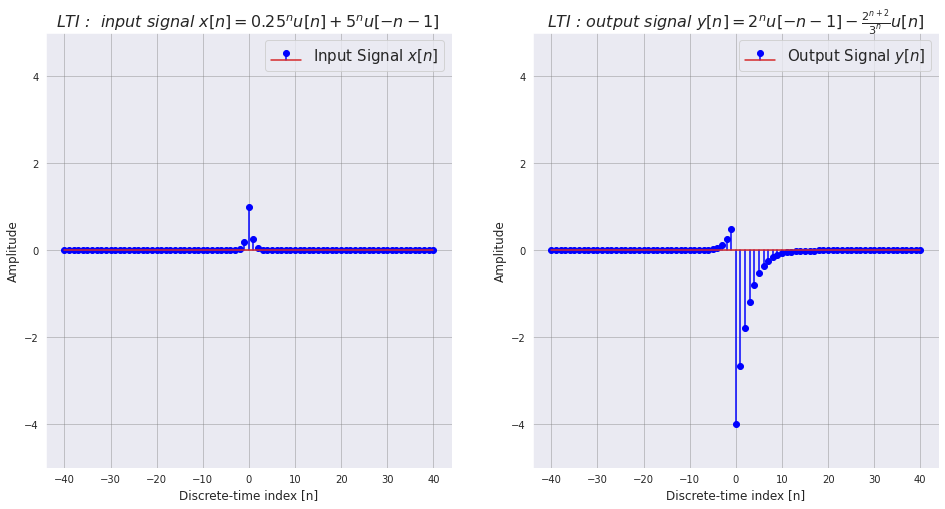

In [3]:
## 1. Define `x[n]` and `y[n]`
N = 40
n = np.arange(-N, N + 1,1, dtype = float)
# n = np.arange(0, N ,1, dtype = float)

x = (0.25**n) * np.heaviside(n, 1) + (5**n) * np.heaviside(-n - 1, 1)
y = (2**n) * np.heaviside(-n - 1, 1) - 4*(2/3)**n * np.heaviside(n, 1)

## 2. Visualize
fig, axs = plt.subplots(1,2, figsize = (16,8))
axs[0].stem(n, x, linefmt = '-b',  markerfmt='bo', label = r"Input Signal $x[n]$")
axs[0].set_title(r"LTI :  input signal $x[n] = 0.25^{n}u[n] + 5^{n}u[-n-1]$ ", size = 16, style = 'italic')
axs[1].stem(n, y, linefmt = '-b',  markerfmt='bo', label = r"Output Signal $y[n]$")
axs[1].set_title(r"LTI : output signal $y[n] = 2^{n}u[-n-1] - \frac{2^{n + 2}}{3^{n}}u[n]$ ", size = 16, style = 'italic')

for idx in range(2) : 
  axs[idx].set_xlabel('Discrete-time index [n]', fontsize = 12)
  axs[idx].set_ylabel('Amplitude',  fontsize = 12)
  axs[idx].grid(True, color = 'gray', alpha = 0.5)
  axs[idx].legend(fancybox = True, prop = {'size': 15})
  axs[idx].set_ylim(-5, 5)

plt.show()

## 2. Calculate the Transfer Function $H(z)$
### **Define Transfer Function**
$$H(z) = \frac{N(z)}{D(z)} =  \frac{\sum\limits_{k = 0}^{M}b_k z^{-k} }{\sum\limits_{k = 0}^{N}a_k z^{-k}}$$

Both $N(z)$ and $D(z)$ are polynomials in z, with z ∈ C. The roots of both polynomials are very important
in the behavior of H(z). The roots of the numerator N(z) are called the zeros of the transfer function. The roots of the denominator N(z) are called the poles of the transfer function.


### **Z-Tranform**
Recall that the DTFT is 
$$ X(e^{j\omega}) = \sum_{n = - \infty}^{\infty}x[n]e^{-j\omega n}, \qquad -\pi \leq \omega \leq \pi$$ Observe that the expression $e^{j\omega}$ is a complex number on the unit circle on the complex plane. We can replace it by a more general complex number z, which does not need to be on the unit circle, and obtain the z-transform:

$$ X(z) = \sum_{n = - \infty}^{\infty}x[n]z^{-n}, \qquad z \in unitCycle$$ 

However we mentioned that we simulated DTFT as a sampled edition of the DFT. Therefore the Z-transform will occur by sampling the unit cycle in the DFT.

The z-transform is more powerful because it is more general. Using it we can also determine, for instance, if a system or a signal has damping on it. Also, we can compute the z-transform even for unstable signals or systems 


#### *INPUT $x[n]\leftrightarrow X(z)$*

* $0.25^{n}u[n] \leftrightarrow \frac{z}{z - 0.25} \qquad \quad |z| > 0.25$
* $-5^{n} u[-n-1] \leftrightarrow \frac{z}{z - 5} \qquad |z| < 5 $

$$X(z) = \frac{z}{z - 0.25} - \frac{z}{z - 5} = \frac{-4.75z}{z^2  - 5.25z + 1.25}, \qquad 0.25 < |z| < 5 $$

#### *OUTPUT $y[n]\leftrightarrow Y(z)$*

* $-2^{n} u[-n-1] \leftrightarrow \frac{z}{z - 2} \qquad |z| < 2 $
* $\frac{2^{n + 2}}{3^{n}}u[n] = 4 \left(\frac{2}{3}\right)^{n}u[n] \leftrightarrow 4 \left( \frac{z}{z - \frac{2}{3}} \right) \qquad |z| > \frac{2}{3}$

$$Y(z) =  - \frac{z}{z - 2} - 4  \left( \frac{z}{z - \frac{2}{3}} \right) = \frac{-15z^{2} + 26z}{3z^{2} - 8z + 4} \qquad \frac{2}{3} < |z| < 2$$


### **1st method (manual) TRANSFER FUNCTION H(z)**

$$H(z) = \frac{\frac{-15z^{2} + 26z}{3z^{2} - 8z + 4}}{\frac{-4.75z}{z^2  - 5.25z + 1.25}} = \frac{-15z^3+104.75z^2-155.25z+32.5}{-14.25z^2+38z-19} = z \frac{ -15 +   104.75 z^{-1}  - 155.25 z^{-2}  + 32.5z^{-3}  }{- 14.25 + 38z^{-1} -19 z^{-2} } = \frac{1 - 4.777z + 3.223 z^{2} - 0.462z^{3}}{-0.585 + 1.169 z - 0.438 z^{2}}$$

### **2nd method (estimation) TRANSFER FUNXTION H(z)**
We are starting from numerical data and want to estimate an analytical expression for it, then we will have to perform some sort of model fit to the data. For signal modeling, we could use **least squares, Pade approximations, Prony's**

We know that the frequency response of an 𝑁-th order linear discrete-time system can be written as $H(ω) = H(z)|_{z = e^{jω}}$. Therefore we see that 
$$\sum_{k = 0}^{N}b_{k}e^{-jkω} - H(ω)(1 + \sum_{k =1}^{N}a_ke^{-jkω}) = 0$$

This equation is linear in the $2N+1$ unknown system difference equation coefficients $b_k$ and $a_k$. Given a desired frequency response 𝐻(𝜔), we would like to find coefficients that meet the above equation exactly for all values of 𝜔. For the general case, that's hard. So instead, we will search for a set of coefficients for a system whose frequency response approximates the desired response at a discrete set of frequencies.

In order to solve for an appropriate set of coefficients using the **linear least squares method(LLS)**, we will use the function `LSIIR()` from `PyDynamic.model_estimation.fit_filter` which :
* Input : $H(ω), \text{No. of nominator coeffs} = 4-1 = 3, \text{No. of denominator coeffs} = 3-1 = 2, f, f_s$
* Output : b, a

Note that $H(ω)$ was calculated as seen in the end of section (Frequency response $H(e^{jω})$.

While there may not be a good way to estimate a priori what the required system order is to meet our design constraints. We could extend this method a bit to use weighted least-squares optimization if needed;.

Moreover we noticed that the problem with this potential solution is, **since the phase is unknown about an existing transfer function, LS may converge on the wrong solution for the phase (see the chart)**

### **3rd method (estimation) TRANSFER FUNXTION H(z)**

We calculated the transfer function by adapting the following methodology
1. Calculate $X(z)$ and $Y(z)$ by using the `sympy.Poly()` function
2. Retrieve the coefficients $b_k, a_k$ by using `coeffs()` function on the calculated $X(z), Y(z)$
3. Last but not least, we used function `signal.TransferFunction()` to calculate the $H(z)$ based on these coefficients

Probably not the best method

### **Difference Equation**
$$X(z)(-15 +   104.75 z^{-1}  - 155.25 z^{-2}  + 32.5z^{-3}) = Y(z)(- 14.25 + 38z^{-1} -19 z^{-2} ) \leftrightarrow$$

$$-14.25 Y(z) + 38Y(z)z^{-1} - 19Y(z)z^{-2} = -15X(z) +104.75X(z)z^{-1} - 155.25X(z)z^{-2} + 32.5X(z)z^{-3} \leftrightarrow$$

$$-14.25y[n] + 38 y[n-1] +19 y[n-2] = -15x[n] +104.75x[n-1] -155.25x[n-2] + 32.5x[n-3] \leftrightarrow$$

$$y[n] = 1.017x[n] - 7.35 x[n-1] + 10.895x[n-2] - 2.28x[n-3] + 2.667 y[n-1] + 1.334 y[n-2]$$


### **Frequency Response $H(e^{jω})$ of IIR filter with transfer function H(z)** 
* Frequency response is the quantitative measure of the output spectrum of a system or device in response to a stimulus, and is used to characterize the dynamics of the system. It is a measure of magnitude and phase of the output as a function of frequency, in comparison to the input

$$ H(e^{jΩ}) = \frac{Y(e^{jΩ})}{X(e^{jΩ})}$$

* This extra analysis in the **continuous frequency** domain is executed for reasons of completeness, to check the **pass regions** of the filter



In [4]:

def display_tf(b, a, mode):
  b = [round(x,3) for x in b]
  a = [round(x,3) for x in a]
  if mode == "inverse" :  b = b[::-1] ; a = a[::-1]
  print()
  print(" "* 7, end = " ")
  print(b[0], end = " ")
  for z_idx in range(1, len(b)):
    if b[z_idx] > 0 : print("+", end = " ")
    if mode == "inverse" :
      print("{}z^({}) ".format(b[z_idx], -z_idx), end = " ")
    else:
      print("{}z^({}) ".format(b[z_idx], z_idx), end = " ")
    
  print()
  print("H(z) = " + "-"*max( len(b), len(a) ) * 13)
  print(" "* 7, end = " ")
  print(a[0], end = " ")
  for z_idx in range(1, len(a)):
    if a[z_idx] > 0 : print("+", end = " ")
    if mode == "inverse" :
      print("{}z^({}) ".format(a[z_idx], -z_idx), end = " ")
    else:
      print("{}z^({}) ".format(a[z_idx], z_idx), end = " ")
  print()
  print()

# Calculate db
def db(x):
  return 20 * np.log10(np.abs(x) / np.abs(x).max())
  

In [5]:
## 1st METHOD H(z)✅
b1 = [-15, 104.75, -155.25, 32.5]
a1 = [-14.25, 38, -19]
H1 = signal.TransferFunction(b1, a1)

## 2nd METHOD H(z)✅
H2w = (np.fft.rfft(y[N:])/np.fft.rfft(x[N:])) *(1/N)
f = fftpack.fftfreq(N//2 + 1)
b2, a2, tau = LSIIR(H2w, Nb = 3,Na = 2, f = f, Fs = 1 )
H2 = signal.TransferFunction(b2, a2)

## 3rd METHOD H(z)✅
# 1. Calculate Z-transform for both input X(z), output Y(z) signals
# [*] Both x, y have n-th index as defined before [-N, ..., 0 , ... , N]. We will only use x[N:], y[N:] to 
#     calculate correclty the coefficients of the Z transform in the formation : a0 + a1* z^{-1} + ... + aN * z^{-N}
z = sympy.symbols('z')
X = sympy.Poly(np.flipud(x[N  :]), z**(-1))
Y = sympy.Poly(np.flipud(y[N  :]), z**(-1))
# 2. Calculate Transfer Function H(z)
# [*] method : We will use `signal.TransferFunction(b, a)`, where
#     a = { coefficients of X } , b = { coefficients of Y }
b3 = np.array( Y.coeffs(), dtype = float)
a3 = np.array( X.coeffs(), dtype = float )
H3 = signal.TransferFunction(b3, a3)


# 3. Display input, output data, n-index and H(z) to visualize the variable (1/z) matching
data = pd.DataFrame(np.vstack([x,y]).T, columns = ["Input x[n]", "Output y[n]"], index = n).T
data.index.name = "n-th index"
print("============================== 1st METHOD ================================")
display_tf(b1,a1, "inverse")
print("============================== 2nd METHOD ================================")
display_tf(b2,a2, "inverse")
print("============================== 3rd METHOD ================================")
display_tf(b3,a3, "inverse")




Least-squares fit of an order 3 digital IIR filter
to a frequency response given by 21 values.

Least squares fit finished after 1 iterations (tau=0).
Final rms error = 4.494431e-02 


============================== 1st METHOD ================================

        32.5 -155.25z^(-1)  + 104.75z^(-2)  -15z^(-3)  
H(z) = ----------------------------------------------------
        -19 + 38z^(-1)  -14.25z^(-2)  

============================== 2nd METHOD ================================

        -0.002 -0.001z^(-1)  + 0.015z^(-2)  -0.101z^(-3)  
H(z) = ----------------------------------------------------
        -0.01 -0.449z^(-1)  + 1.0z^(-2)  

============================== 3rd METHOD ================================

        -4.0 -2.667z^(-1)  -1.778z^(-2)  -1.185z^(-3)  -0.79z^(-4)  -0.527z^(-5)  -0.351z^(-6)  -0.234z^(-7)  -0.156z^(-8)  -0.104z^(-9)  -0.069z^(-10)  -0.046z^(-11)  -0.031z^(-12)  -0.021z^(-13)  -0.014z^(-14)  -0.009z^(-15)  -0.006z^(-16)  -0.004z^(-17)  -0.003z^(-

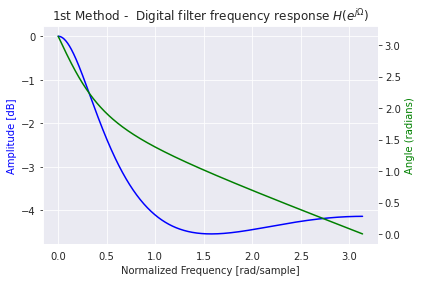

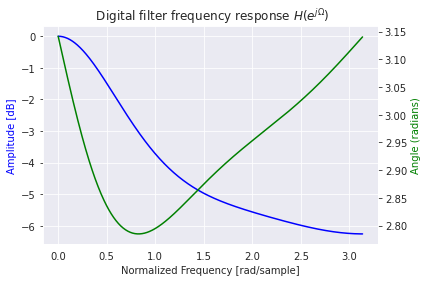

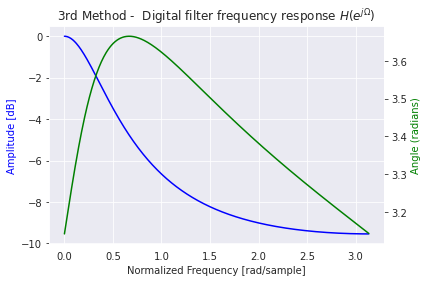

In [6]:
# 4. Calculate Frequency Response

def plot_freq_response(w, Y,  method = ""):
  magnitude = db(abs(Y))
  angles    = np.unwrap(np.angle(Y))
  fig = plt.figure()
  ax1 = fig.add_subplot(111)
  plt.title(method + r' Digital filter frequency response $H(e^{jΩ})$')
  plt.plot(w, magnitude , 'b', label = "magnitude (1st Method)")
  plt.ylabel('Amplitude [dB]', color='b')
  plt.xlabel('Normalized Frequency [rad/sample]')
  ax2 = ax1.twinx()
  plt.plot(w, angles, 'g')
  plt.ylabel('Angle (radians)', color = 'g')
  plt.grid()
  plt.axis('tight')
  plt.show()

## 1st METHOD H(z)✅
w1, Y1 = signal.freqz(b1, a1)
plot_freq_response(w1, Y1, "1st Method - ")

## 2nd METHOD H(z)✅
w2, Y2 = signal.freqz(b2, a2)
plot_freq_response(w2, Y2)

## 3rd METHOD H(z)✅
w3, Y3 = signal.freqz(b3, a3)
plot_freq_response(w3, Y3,"3rd Method - ")



## 3. Zero - Pole diagram & Region of Convergence (ROC)

### **Poles & Zeros**
A pole-zero plot shows the location in the complex plane of the poles and zeros of the transfer function of a dynamic system,. By convention, the poles of the system are indicated in the plot by an X while the zeros are indicated by a circle or O.

We will use function `scipy.signal.tf2zpk()` that returns **zero, pole, gain**(z, p, k) representation from a numerator, denominator representation of a linear filter.

#### Zeros
$$ z = b_{k} \text{ such that } N(z)|_{z = b_{k}} = 0$$

#### Poles
$$ z = a_{k} \text{ such that } D(z)|_{z = a_{k}} = 0$$

we will only plot the zeros-poles for the 1st and the 2nd method. The 3rd method was just an idea of how to find many $a_k, b_k$.


### **Region of Convergence (ROC) (1st Method)**

#### Input X(Z)
* **Poles** : $z \in \{ 0.25, 5\}$
* **Zeros** : $z = 0$
$$0.25 < |z| < 5 \quad \text{(two-sided)}$$

#### Output Y(Z)
* **Poles** : $z \in \{ 0.666, 2\}$
* **Zeros** : $z \in \{ 0, 1.7333\}$
$$\frac{2}{3} < |z| < 2 \quad \text{(two-sided)}$$

#### System H(z) = Y(z) / X(z) (unstable, non-causal)

* **ZERO & POLES** : 
  * **Poles** : $z \in \{0.25, 1.733, 5 \}$
  * **Zeros** : $z \in \{0, 0.666, 2 \}$
  * We see that the poles of the output became zeros for the system $\mathcal{S}$ and its zeros became poles for the system 
  * Since the *order of the numerator* $N = 4$ and the *order of the numerator* $M = 3$ , $N > M$, there extra $N - M = 4 - 3 = 1$ zero at $z = \infty$. So, in order to properly use the `zplot()` function from the `audiolazy` library we will exclude this extra $z$.

* **ROC & CAUSALITY**
  * Now we know that the ROC of the multiplication of two $\mathcal{Z}$-transforms equals the intersection of the ROCs of the individual $\mathcal{Z}$-transforms, unless there is pole-zero cancellation, in which case the resulting ROC can be bigger than the intersection
  * Both $x[n]$ and $y[n]$ are **non-causal** signals since they have non-negative values for some $n < 0$, and this is why both ROCs are two-sided. 
  * In order to fulfill both restrictions the only ROC which is accepted is 
$$ \frac{2}{3} < |z| < 2 \quad \text{(two-sided)}$$
which also **includes the unit circle**, Moreover the system will be **non-causal**. Furthemore, this ROC does not include any poles.
  * We can also see that the *order of the numerator* $N = 4$ is **greater** than the *order of the denominator* $M = 3$ , and we could conclude that the system is **non-causal**.
$$N > M$$

* **STABILITY**

  * Last but not least, the system will be **stable** since the ROC includes the unit circle $|z| = 1$




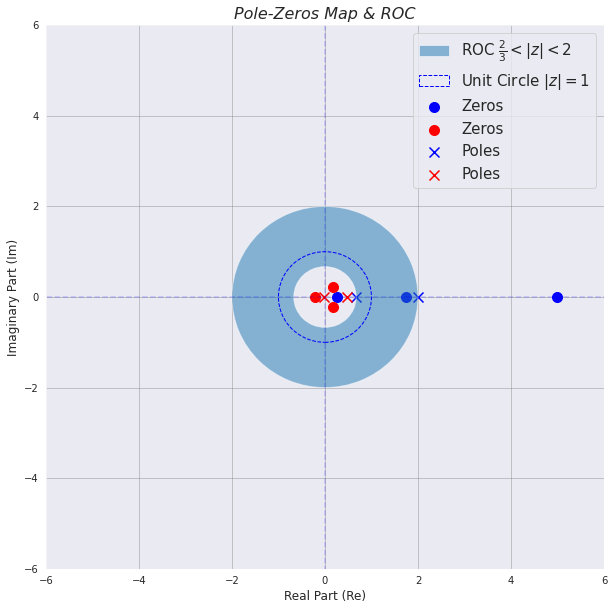

In [7]:
from audiolazy import z;
## 1. Calculate both zeros and poles of the LTI system
# 1st METHOD H(z)✅
zeros1, poles1, _ = signal.tf2zpk(b1, a1)
# 2nd METHOD H(z)✅
zeros2, poles2, _ = signal.tf2zpk(b2, a2)

zeros = [zeros1, zeros2]
poles = [poles1, poles2]

## 2. Visualize zeros , poles
def plot_pole_zero(zeros, poles, ROC, lim = 6):

  fig, ax = plt.subplots(figsize = (10, 10))
  circle = plt.Circle((0, 0), radius = 1, color = 'b', linestyle = '--', linewidth = 1, fill = False, label = r"Unit Circle $|z| = 1$")
  ax.add_patch(ROC)
  ax.add_patch(circle)
  colors = ["b", "r"]
  for z, c in zip(*[zeros, colors]) :
    ax.scatter(z.real,z.imag, color = c , marker = 'o', s = 100, label = "Zeros")
  for p, c in zip(*[poles, colors]) :
    ax.scatter(p.real,p.imag, color = c , marker = 'x', s = 100, label = "Poles")
  ax.axhline(y = 0, xmin = -5.0, xmax = 5.0, color='blue', linestyle = '--',alpha = 0.2)
  ax.axvline(x = 0, ymin = -5.0, ymax = 5.0, color='blue', linestyle = '--',alpha = 0.2)
  ax.set_title(r"Pole-Zeros Map & ROC", size = 16, style = 'italic')
  ax.set_xlabel('Real Part (Re)', fontsize = 12)
  ax.set_ylabel('Imaginary Part (Im)', fontsize = 12)
  ax.set_xlim(-lim,lim)
  ax.set_ylim(-lim,lim)
  ax.grid(True, color = 'gray', alpha = 0.5)
  ax.legend(fancybox = True, prop = {'size': 15})
  plt.show()


roc = Wedge((0,0), 2, 0, 360, width = 1.33, alpha = 0.5, label = r"ROC $\frac{2}{3} < |z| < 2$")
plot_pole_zero(zeros, poles, roc, lim = 6)


## 4. LTI Responses
Having found the transfer function $H(z)$ we can calculate the **unit** and **impulse** response. In discrete time the unit impulse is the first difference of the unit step, and the unit step is the running sum of the unit impulse.
$$\delta[n] = u[n] - u [n - 1]$$

$$u[n] = \sum_{m = - \infty}^{n}\delta[m]$$

### **Impusle Response (Input $x[n] = \delta[n]$)**
We would like to measure the impulse response of an LTI system,
described by the impulse response h[n] (which is the inverse Z-transform of the transfer function)

<a href="https://ibb.co/0j46JtV"><img src="https://i.ibb.co/TBj7hLq/1.png" alt="1" border="0"></a>

This can be practically difficult because input amplitude is often limited. A
very short pulse then has very little energy.

$$y[n] = h[n] * x[n] \rightarrow y[n] = h[n] * \delta[n] \rightarrow Y(z) = H(z) \cdot 1 \rightarrow Y(z) = H(Z) \rightarrow y[n] = h[n]$$

We know that

$$H(z) = \frac{-15z^3+104.75z^2-155.25z+32.5}{-14.25z^2+38z-19} = -15z + 64.75 + 15.75\frac{1}{z-2} - 21.667 \frac{1}{z - \frac{2}{3}}$$

Therefore, the inverse transform Z of $H(z)$ is
$$h[n] = \mathcal{Z}^{-1}\{H(z)\} = 64.75\delta[n] - 15 \delta[n+1] + 15.75 \cdot 2^{n-1}u[n-1] + 21.677 \cdot \left(\frac{2}{3}\right)^{n-1}u[n-1]$$


### **Step Response (Input $x[n] = u[n]$)**

A common alternative is to measure the step response $s[n]$, the response
to a unit step input $u[n]$
<a href="https://ibb.co/Hh3hdjM"><img src="https://i.ibb.co/wcjcsfb/Screen-Shot-2020-12-09-at-18-10-20.png" alt="Screen-Shot-2020-12-09-at-18-10-20" border="0"></a>

$$y[n] = h[n] * x[n] \rightarrow y[n] = h[n] * u[n] \rightarrow y[n] = s[n] = h[n] * u[n]$$


### **NOTES**
* Below we did 2 things : (1) defined manually $h[n]$ and plotted it (impulse responsed for ground truth)(2) used function `lfilter()` for the 3 methods (with the respective b,a) to calculate unit and impulse response.
* We see that the 2nd method (that applies least square algorithm) fails to generate the necessary outcome. This is because of the wrong phase calculation we mentioned before. Interestingly , the 3rd method approximates better the ground truth result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


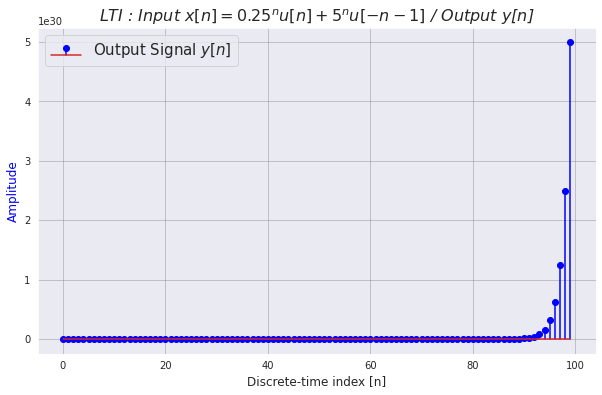

In [8]:
## 1. Define `x[n]` and `y[n]`
N = 100
n = np.arange(0, N,1, dtype = float)
h = 64.75 * signal.unit_impulse(N , 0) - 15 *  signal.unit_impulse(N,1) + 15.75 * 2**(n - 1)* np.heaviside(n - 1, 1) + 21.67* (2/3)**(n-1)* np.heaviside(n - 1, 1)

## 2. Visualize
def plot_response(y, exponent = None, N  = 100, dbScale = False, name = "", color = "b") :
  n = np.arange(N)
  if dbScale : y = y = db(np.abs(y))
  fig, ax = plt.subplots(figsize = (10,6))
  ax.stem(n, y, linefmt = '-{}'.format(color),  markerfmt = '{}o'.format(color), label = r"Output Signal $y[n]$")
  if exponent is not None: plt.plot(n, 1.7368*(exponent)**n, "r--")
  ax.set_title(r"LTI : Input ${}$ / Output y[n]".format(name), size = 16, style = 'italic')
  ax.set_xlabel('Discrete-time index [n]', fontsize = 12)
  ax.set_ylabel('Amplitude',  fontsize = 12, color = "b")
  ax.grid(True, color = 'gray', alpha = 0.5)
  ax.legend(fancybox = True, prop = {'size': 15})
  plt.show()

plot_response(y = h,  N  = 100, dbScale = False, name = "x[n] = 0.25^{n}u[n] + 5^{n}u[-n-1]")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


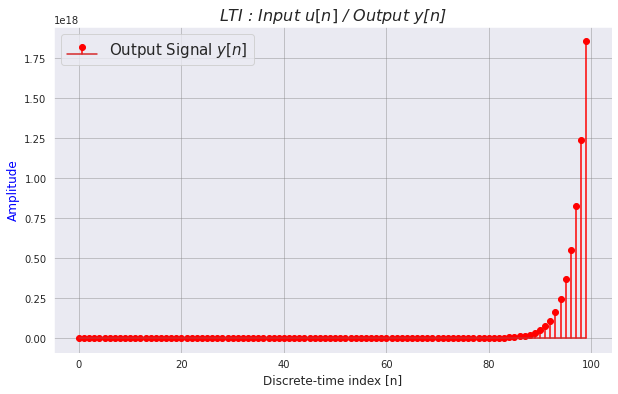

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


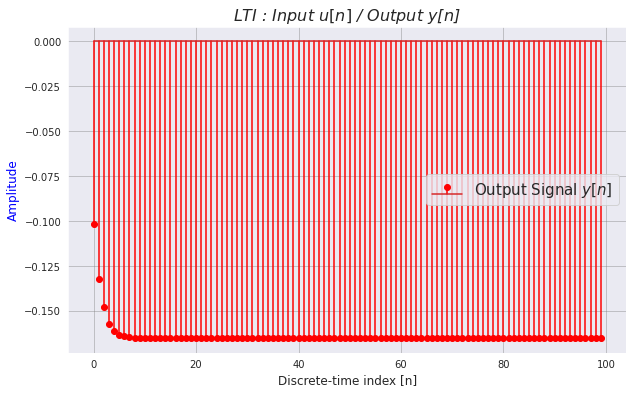

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


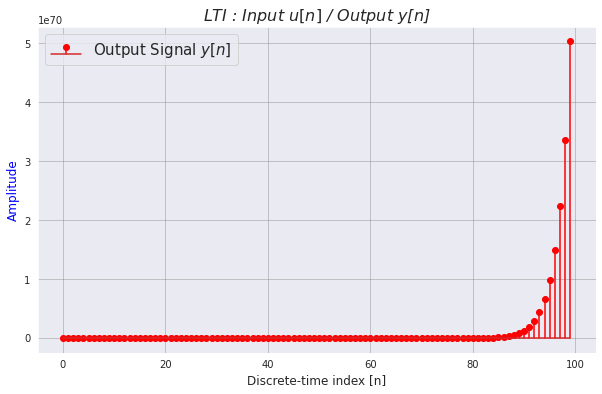

In [9]:
## INPUT : x[n] = u[n] | OUTPUT : Step Reponse y[n] = s[n]
# 1. Define the input `x[n] = δ[n]`
L = 100
n = np.arange(100)
x = np.heaviside(n, 1)

# 2. Now calculate the impulse response for the 3 methods
# 1st METHOD h[n]✅
y1 = signal.lfilter(b1[::-1], a1[::-1], x)
plot_response(y1,  N  = L , dbScale = False, name = "u[n]", color = "r")

# 2nd METHOD h[n]✅
y2 = signal.lfilter(b2, a2, x)
plot_response(y2,  N  = L , dbScale = False, name = "u[n]",  color = "r")

# 3rd METHOD h[n]✅
y3 = signal.lfilter(b3, a3, x)
plot_response(y3,  N  = L , dbScale = False, name = "u[n]",  color = "r")

## EXTRA
---

In [10]:
## 1. Estimate H(z) with spectral density (https://github.com/dnvgl/qats/blob/24bdb5f61829611d79e8cda086fdf7ce5c3c3926/qats/signal.py )
# from matplotlib.mlab import psd, csd
# def tfe(x, y):
#    """estimate transfer function from x to y, see csd for calling convention"""
#    f, Pxy  = signal.csd(x, y)  # Pxy is the cross power spectral density of x and y,
#    _, Pxx = signal.welch(x)    # Pxx is the power spectral density of x, calculated using the welch method
#    return f, Pxy / Pxx
# f, H = tfe(x,y)
# print(H)
# plt.plot(1. / f[(0. < f) & (f <= 0.5)], abs(H[(0. < f) & (f <= 0.5)]))


## 2. Zero-pole Map
# [*] 1st method
# H = control.TransferFunction(b, a)
# control.pzmap(H)
# [*] 2nd method
# H = (-15*z**3 + 104.75*z**2 -155.25*z + 32.5)/ (-14.75 * z**3 + 38 * z**2 -19*z );
# H.zplot();
# H.plot();